In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook

In [2]:
trajectory = pd.read_csv("https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/trajectory-1-Copy.csv")
sns.set()

In [3]:
x = trajectory['x']
y = trajectory['y']
t = pd.Series(range(10000)) / 250

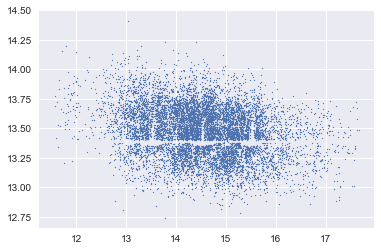

In [4]:
plt.scatter(x, y, s=1)

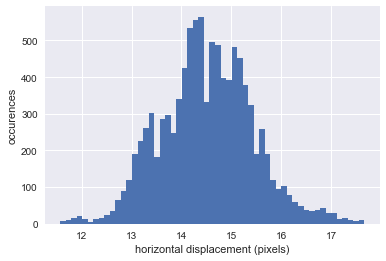

In [5]:
plt.hist(x, 'auto')
plt.xlabel("horizontal displacement (pixels)")
plt.ylabel("occurences")
plt.show()

/home/johnny/kod/py/bin/venv/py3/phx444/labs/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


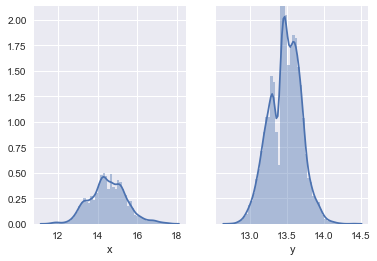

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.distplot(x, ax=ax1)
sns.distplot(y, ax=ax2)
plt.show()

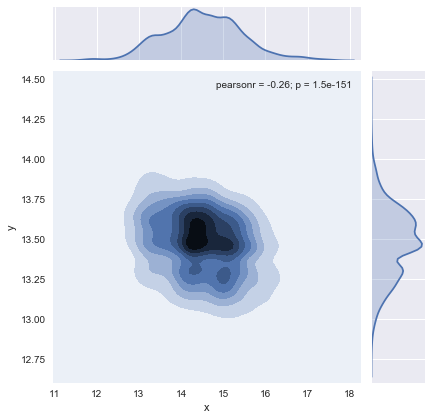

In [7]:
sns.jointplot(x, y, kind='kde')

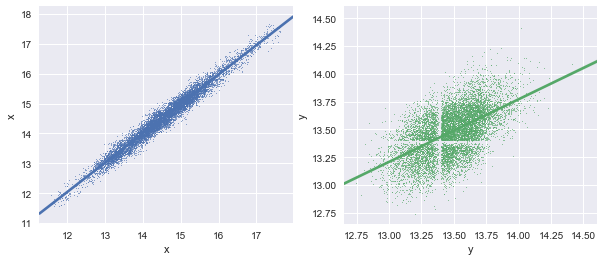

In [8]:
n = 4
xi = x[:-n]
xin = x[n:]
yi = y[:-n]
yin = y[n:]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
sns.regplot(xin, xi, scatter_kws={"s":1}, ax=ax1)
sns.regplot(yin, yi, scatter_kws={"s":1}, ax=ax2)

In [9]:
source = ColumnDataSource(data=dict(x=y, y=y))

plot = figure(y_range=(12, 15), plot_width=400, plot_height=400)

plot.scatter('x', 'y', source=source, size=.5)

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var n = n.value;
    x = data['x']
    y = data['y']
    for (i = 0; i < x.length; i++) {
        y[i + n] = x[i];
    }
    source.change.emit();
    """)

n_slider = Slider(start=0, end=50, value=0, step=1,
                    title="n", callback=callback)
callback.args["n"] = n_slider

layout = row(
    plot,
    widgetbox(n_slider),
)

output_notebook()

show(layout)

Loading BokehJS ...

In [10]:
source = ColumnDataSource(data=dict(x=x, y=x))

plot = figure(y_range=(11, 18), plot_width=400, plot_height=400)

plot.scatter('x', 'y', source=source, size=.5)

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var n = n.value;
    x = data['x']
    y = data['y']
    for (i = 0; i < x.length; i++) {
        y[i + n] = x[i];
    }
    source.change.emit();
    """)

n_slider = Slider(start=0, end=200, value=0, step=1,
                    title="n", callback=callback)
callback.args["n"] = n_slider

layout = row(
    plot,
    widgetbox(n_slider),
)

output_notebook()

show(layout)

Loading BokehJS ...

In [11]:
np.fft.fft(x)

array([145194.83114264   +0.j        ,   1551.19741957+1037.90800736j,
         -661.43841673-1677.35286791j, ...,
          390.09539697+1962.66902485j,   -661.43841673+1677.35286791j,
         1551.19741957-1037.90800736j])

In [104]:
def fourierTransformy(t, y):
    #do fft on oscilloscope y data
    t_step = t[2]- t[1]
    ffty = np.fft.fft(abs(y))
    
    #clean up and normalize
    ffty = np.fft.fftshift(ffty)
    ffty= 2*ffty / float(len(y))


    #determine the t step and window length for performing fft on x-axis (t)
    win_length = len(t)

    fftfreq = np.fft.fftfreq(win_length, t_step)
    fftfreq = np.fft.fftshift(fftfreq)

    return fftfreq, ffty



In [105]:
ft_ty, ft_y = fourierTransformy(t,y)

In [106]:
ft_tx, ft_x = fourierTransformy(t,x)

/home/johnny/kod/py/bin/venv/py3/phx444/labs/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


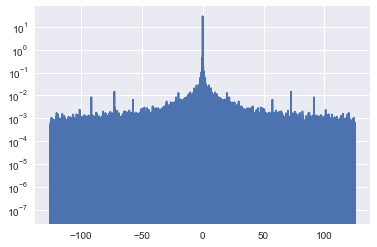

In [107]:
plt.plot(ft_tx, ft_x)
plt.yscale('log')
# plt.plot(ft_tx, ft_x, alpha=.5)

In [48]:
from scipy.fftpack import fft

class model(object):

    """
    A class which holds models corresponding to the lab

    Attributes
    :measurementXValues: The measured X values (used to fit parameters)
    :measurementYValues: The measured Y values (used to fit parameters)
    :measurementYError: The measured y error (used to fit parameters)
    :name: the name of the model, will be displayed on plot legend

    Methods
    :model: a placeholder for the general method which will add the current
    model to a plot
    """

    def __init__(
        self,
        name='Unknown'):

        """models need a name"""
        self.name = name

    def model(self):
        """
        All models need to be able to model something
        """
        pass

class fourierModel(model):

    """
    We need to FT and model several types of input

    Attributes
    :numPoints: The number of points used during the Fourier Transform
    :sampleSpacing: How far apart the points should be
    :name: passed to model.__init__(name) as the name which shows up on plots
    """

    def __init__(self,
                 numPoints=10000,
                 sampleSpacing=(1/250),
                 name='Modeled Waveform'):

        """
        :numPoints: number of points to sample
        :sampleSpacing: how far apart the sample points are

        """
        self.N = numPoints
        self.T = sampleSpacing
        self.time = np.linspace(0.0, self.N * self.T, self.N)

        # by default, assume linear relationship between time and voltage
        self.voltageFunction = self.time

        super(fourierModel, self).__init__(name)

    def transformX(self):
        """Produce the frequency bins for a single frequency wave
        :returns: An array with the bins for frequency (IE the x axis)

        return np.linspace(0.0, 1.0 / (2.0 * self.T), self.N//2)

        T is the spacing between points
        N is the number of points

        """

        return np.linspace(0.0, 1.0 / (2.0 * self.T), self.N//2)


    def transformY(self):
        """Transfrom the voltage of a sine function
        :returns: an array with the FT of the voltage of a sine

        return 20 * np.log10(
                2.0/self.N *
                np.abs(fft(self.voltageFunction)[0:self.N//2]))
        """

        return 2.0/self.N * np.abs(fft(self.voltageFunction)[0:self.N//2])


    def model(self, style='--'):
        """Transform and plot both X and Y domains
        :returns: nothing, but adds sine to current plot

        """

        plt.plot(
            self.transformX(),
            self.transformY(),
            style,
            label=self.name
        )

        return


In [49]:
test = fourierModel()

In [78]:
test.voltageFunction = x

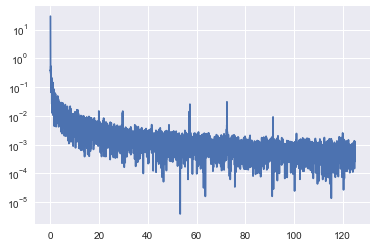

In [81]:
plt.plot(test.transformX(), test.transformY())
plt.yscale('log')

In [ ]:
test.